In [1]:
import json
import sys
sys.path.insert(0, '..')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from environments.DKT_model import get_custom_DKT_model

In [2]:
#load in model
saved_data_folder = '../education/saved_data'
student_model = get_custom_DKT_model(saved_data_folder = saved_data_folder)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 248)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 248)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 200)         359200    
_________________________________________________________________
outputs (TimeDistributed)    (None, None, 124)         24924     
Total params: 384,124
Trainable params: 384,124
Non-trainable params: 0
_________________________________________________________________
None


In [3]:
best_model_weights = f'{saved_data_folder}/saved_model_weights/bestvalmodel'
student_model.load_weights(best_model_weights)

In [4]:
all_problems_file_name = f'{saved_data_folder}/all_problems.txt'
all_problems = []

with open(all_problems_file_name, 'r') as filehandle:
    for line in filehandle:
        problem = line[:-1] # remove linebreak which is the last character of the string
        all_problems.append(int(problem))

In [5]:
# student_model.evaluate(test_dataset, verbose)

In [6]:
def format_input(problem_seq, answer_seq):
    if len(problem_seq) == 0:
        return np.array([[[-1]*n_features]])
    x_seq = []
    for problem, answer in zip(problem_seq, answer_seq):
        idx = problem *2 + answer
        x = np.zeros(n_features)
        x[idx] = 1
        x_seq.append(x)
    return np.array([x_seq])

In [7]:
def insert_node(node, child_node):
    if node != child_node and node not in prereq_graph[child_node]:
        prereq_graph[child_node].append(node)
    for grandchild_node in out_nodes[child_node]:
        insert_node(node, grandchild_node)
def insert_node_parents(node, parent_node):
    if node != parent_node and node not in child_graph[parent_node]:
        child_graph[parent_node].append(node)
    for grandparent_node in incoming_nodes[parent_node]:
        insert_node_parents(node, grandparent_node)

## Use DKT to get dependencies between problms

In [8]:
n_problems = len(all_problems)
n_features = 2*n_problems

In [9]:
problems_array = []
n_rep = 3
for problem in all_problems:
    problems_array.append(student_model.predict(format_input([problem for _ in range(n_rep)], [1 for _ in range(n_rep)]))[0][-1])

In [10]:
problems_array = np.vstack(problems_array)
for problem in all_problems:
    problems_array[:,problem] = problems_array[:,problem]/sum(problems_array[:,problem])

In [11]:
#load in problems
with open(f'{saved_data_folder}/problem_to_idx.json', 'r') as f:
    problem_to_idx = json.load(f)
all_nodes = [int(problem) for problem in problem_to_idx]

In [12]:
thresh1 = 0.0090
np.sum(problems_array>thresh1)

378

In [13]:
problem_edges = []
problem_edges_weights = []

for i in all_problems:
    for j in all_problems:
        if problems_array[i][j] > thresh1 and i != j:
            if i in all_nodes and j in all_nodes:
                problem_edges.append((i, j))
                problem_edges_weights.append(problems_array[i][j])

print(len(problem_edges))


143


In [14]:
graph = nx.DiGraph()
graph.add_edges_from(problem_edges)

In [15]:
#Fix cycles by removing the weakest links in cycles
len_cycle = 2
removed_edges = []
while len(list(nx.simple_cycles(graph))) > 0:
    found = False
    for cycle in list(nx.simple_cycles(graph)):
        if len(cycle) == len_cycle:
            found = True
            
            pairs_to_check = []
            pair_weights = []
            for i in range(len_cycle-1):
                pairs_to_check.append((cycle[i], cycle[i+1]))
                pair_weights.append(problems_array[cycle[i], cycle[i+1]])
            pairs_to_check.append((cycle[-1], cycle[0]))
            pair_weights.append(problems_array[cycle[-1], cycle[0]])
            
            
            idx_min = np.argmin(pair_weights)
            problem_edges.remove(pairs_to_check[idx_min])
            removed_edges.append((pairs_to_check[idx_min], len_cycle))
    graph = nx.DiGraph()
    graph.add_edges_from(problem_edges)
    if not found:
        len_cycle += 1

In [16]:
print(list(nx.simple_cycles(graph)))
print(len(problem_edges))

[]
133


In [17]:
# Sort the problem edges

In [18]:
sorted_vals = [pair for pair in sorted(zip(problem_edges, problem_edges_weights), key=lambda pair: -pair[1])]
sorted_problem_edges, sorted_problem_edge_weights = zip(*sorted_vals)

In [19]:
# sorted_problem_edges = [problem_edge for problem_edge in sorted_problem_edges if problem_edge in problem_edges]

In [20]:
N_edges = 80
problem_edges_to_use = sorted_problem_edges[0:N_edges]

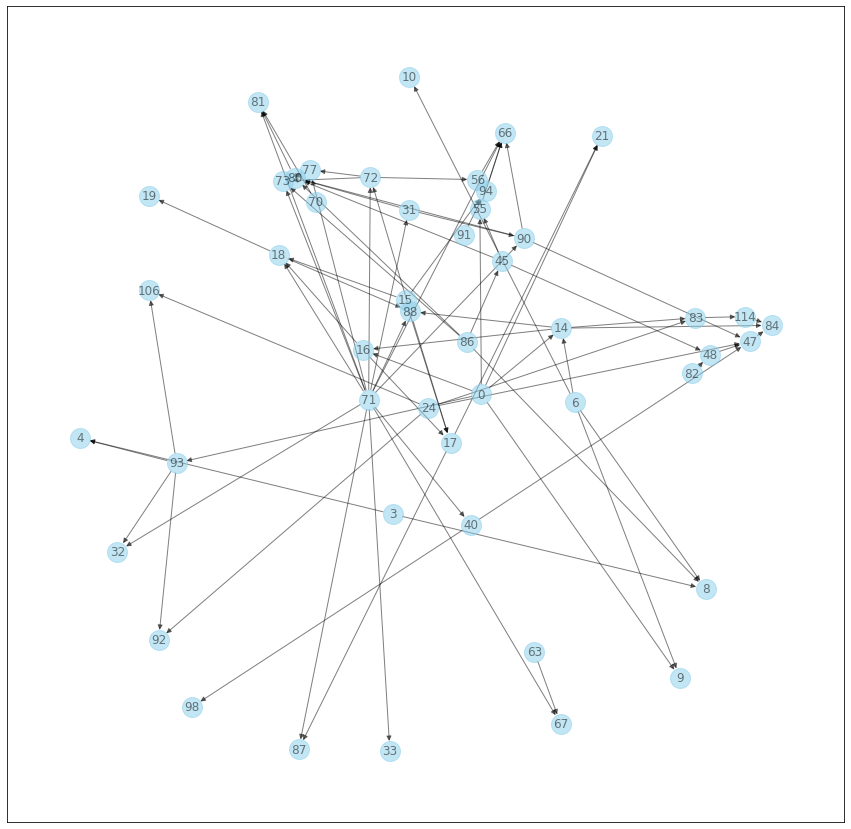

In [21]:
graph = nx.DiGraph()
graph.add_edges_from(problem_edges_to_use)

plt.figure(figsize=(15,15))
plt.tight_layout()
nx.draw_networkx(graph, arrows=True, node_color = "skyblue", alpha = 0.5, node_size = 400)
# nx.draw(G, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)

plt.savefig("g2.png", format="PNG")
plt.show()

In [22]:
incoming_nodes = {node: [x for x, y in list(graph.in_edges(node))] for node in list(graph.nodes)}
out_nodes = {node: [y for x, y in list(graph.out_edges(node))] for node in list(graph.nodes)}

In [23]:
prereq_graph = {node: [] for node in all_nodes}
child_graph = {node: [] for node in all_nodes}

In [24]:
for node in incoming_nodes:
    insert_node_parents(node, node)

In [25]:
for node in out_nodes:
    insert_node(node, node)

In [ ]:
# import json
# with open(f'child_graph_C{N_edges}.json', 'w') as f:
#     json.dump(child_graph, f)
# with open(f'prereq_graph_C{N_edges}.json', 'w') as f:
#     json.dump(prereq_graph, f)